In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drowsiness-detection-model-dataset/__results__.html
/kaggle/input/drowsiness-detection-model-dataset/__notebook__.ipynb
/kaggle/input/drowsiness-detection-model-dataset/__output__.json
/kaggle/input/drowsiness-detection-model-dataset/custom.css
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/06_5_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/37_10_mov.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/08_10_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/39_5_MOV.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/14_10_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/11_10_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/47_5_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/47_0_mp4.mp4
/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/07_5_mp4.mp4
/kaggle/

In [2]:
!pip install mediapipe opencv-python-headless



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

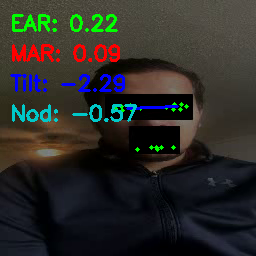


✅ All done! Processed 764569 frames.
📄 Saved to: /kaggle/working/combined_dataset.csv


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# === MediaPipe Face Mesh Setup ===
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# === EAR Calculation ===
def compute_EAR(landmarks, w, h, indices):
    coords = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in indices]
    A = np.linalg.norm(np.array(coords[1]) - np.array(coords[5]))
    B = np.linalg.norm(np.array(coords[2]) - np.array(coords[4]))
    C = np.linalg.norm(np.array(coords[0]) - np.array(coords[3]))
    return (A + B) / (2.0 * C)

# === MAR Calculation ===
def compute_MAR(landmarks, w, h, indices):
    coords = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in indices]
    vertical = np.linalg.norm(np.array(coords[2]) - np.array(coords[3]))
    horizontal = np.linalg.norm(np.array(coords[0]) - np.array(coords[5]))
    return vertical / horizontal

# === Head Tilt Calculation ===
def compute_head_tilt(landmarks, w, h, left_indices, right_indices):
    left = [(landmarks.landmark[i].x * w, landmarks.landmark[i].y * h) for i in left_indices]
    right = [(landmarks.landmark[i].x * w, landmarks.landmark[i].y * h) for i in right_indices]
    left_center = np.mean(left, axis=0).astype(int)
    right_center = np.mean(right, axis=0).astype(int)
    delta_y = right_center[1] - left_center[1]
    delta_x = right_center[0] - left_center[0]
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    return angle, left_center, right_center

# === Head Nod (Vertical Movement) ===
def compute_head_nod(prev_nose_y, current_nose_y):
    if prev_nose_y is None:
        return 0.0
    return current_nose_y - prev_nose_y

# === Extract Label from Filename ===
def extract_label_from_filename(filename):
    if "_0" in filename:
        return 0
    elif "_5" in filename:
        return 5
    elif "_10" in filename:
        return 10
    return -1

# === Detect Upright Face and Rotate if Needed ===
def auto_rotate_to_upright(frame):
    for angle in [0, 90, 180, 270]:
        test_frame = frame
        if angle != 0:
            test_frame = cv2.rotate(frame, {90: cv2.ROTATE_90_CLOCKWISE, 180: cv2.ROTATE_180, 270: cv2.ROTATE_90_COUNTERCLOCKWISE}[angle])
        rgb = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
        result = face_mesh.process(rgb)
        if result.multi_face_landmarks:
            return test_frame
    return None

# === Process One Video ===
def process_video(video_path, save_frame_dir, show_preview=True):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    output_data = []

    video_name = os.path.basename(video_path).split(".")[0]
    video_id = video_name.split("_")[0]
    label = extract_label_from_filename(video_path)

    prev_nose_y = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # On first frame, correct rotation if needed
        if frame_count == 1:
            corrected = auto_rotate_to_upright(frame)
            if corrected is None:
                print(f"⚠️ Skipping {video_name}, no upright face detected.")
                return []
            frame = corrected

        h, w = frame.shape[:2]
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]

            left_eye = [33, 160, 158, 133, 153, 144]
            right_eye = [263, 387, 385, 362, 380, 373]
            mouth = [78, 308, 13, 14, 82, 312]
            nose_tip = 1

            ear_left = compute_EAR(landmarks, w, h, left_eye)
            ear_right = compute_EAR(landmarks, w, h, right_eye)
            ear = (ear_left + ear_right) / 2.0
            mar = compute_MAR(landmarks, w, h, mouth)
            head_tilt, left_center, right_center = compute_head_tilt(landmarks, w, h, left_eye, right_eye)

            # === Head Nod
            nose_y = landmarks.landmark[nose_tip].y * h
            head_nod = compute_head_nod(prev_nose_y, nose_y)
            prev_nose_y = nose_y

            # === Save frame
            image_filename = f"vid{video_id}_frame{frame_count}.jpg"
            image_path = os.path.join(save_frame_dir, image_filename)
            cv2.imwrite(image_path, frame)

            # === Annotate Preview
            if show_preview and frame_count % 300 == 0:
                preview = frame.copy()
                for idx in left_eye + right_eye + mouth:
                    x = int(landmarks.landmark[idx].x * w)
                    y = int(landmarks.landmark[idx].y * h)
                    cv2.circle(preview, (x, y), 2, (0, 255, 0), -1)
                cv2.line(preview, tuple(left_center), tuple(right_center), (255, 0, 0), 2)
                cv2.putText(preview, f"EAR: {ear:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                cv2.putText(preview, f"MAR: {mar:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                cv2.putText(preview, f"Tilt: {head_tilt:.2f}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                cv2.putText(preview, f"Nod: {head_nod:.2f}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 0), 2)
                clear_output(wait=True)
                cv2_imshow(preview)

            # === Save data
            output_data.append([
                f"vid{video_id}", frame_count, ear, mar, head_tilt, head_nod, label, image_path
            ])

    cap.release()
    return output_data

# === Process Folder ===
def process_folder(folder_path, save_frame_dir, output_csv_path):
    os.makedirs(save_frame_dir, exist_ok=True)
    all_data = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".mp4"):
            full_path = os.path.join(folder_path, filename)
            print(f"🎞️ Processing {filename} ...")
            video_data = process_video(full_path, save_frame_dir)
            all_data.extend(video_data)

    # Write final CSV
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['video_id', 'frame', 'EAR', 'MAR', 'Head_Tilt', 'Head_Nod', 'Label', 'img_path'])
        writer.writerows(all_data)

    print(f"\n✅ All done! Processed {len(all_data)} frames.")
    print(f"📄 Saved to: {output_csv_path}")

# === RUN ===
input_video_folder = "/kaggle/input/drowsiness-detection-model-dataset/mp4_data_augmented/"
output_frame_folder = "/kaggle/working/frames"
output_csv_file = "/kaggle/working/combined_dataset.csv"
process_folder(input_video_folder, output_frame_folder, output_csv_file)
